# less stochastic optimizer


# 3. optimization per minibatch


## 3.2. newton(hessian) method

### 3.2.1. dataset

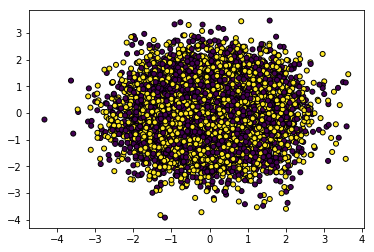

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn import datasets
n_features = 30
X, label = datasets.samples_generator.make_classification(
    n_samples=10000, n_features=n_features, n_redundant=0, n_informative=2, n_clusters_per_class=2, flip_y=0.01, random_state=1)


plt.scatter(X[:, 0], X[:, 1], marker='o', c=label, s=25, edgecolor='k')
X = X.reshape([-1, n_features])
label = label.reshape([-1, 1]).astype('float32')

### 3.2.2. build graph

In [2]:
import tensorflow as tf

x = tf.placeholder(tf.float32, shape=[None, n_features])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

tf.set_random_seed(0xC0FFEE)
y = x
for layer in range(4):
    y = tf.layers.dense(inputs=y, units=10, activation=tf.nn.relu)
y = tf.layers.dense(inputs=y, units=1, activation=tf.nn.sigmoid)
loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=y_, logits=y)

INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


### 3.2.3. optimizer commons

In [3]:
from tensorflow.python.training import optimizer
from tensorflow.python.util import nest

var_list = (tf.trainable_variables() + tf.get_collection(tf.GraphKeys.TRAINABLE_RESOURCE_VARIABLES))
var_list += tf.get_collection(tf.GraphKeys._STREAMING_MODEL_PORTS)

processors = [optimizer._get_processor(v) for v in var_list]
var_refs = [p.target() for p in processors]

In [4]:
sess = tf.Session()

### 3.2.4. optimizer gradient desent

In [5]:
# compute_gradients
grads = tf.gradients(
        loss, var_refs,
        grad_ys=None, aggregation_method=None, colocate_gradients_with_ops=True)
grads_and_vars = list(zip(grads, var_list))

In [6]:
opt = tf.train.GradientDescentOptimizer(0.5)
first_order_optimizer_op = opt.apply_gradients(grads_and_vars)

In [7]:
sess.run(tf.global_variables_initializer())

for i in range(101):
    samplesX, samplesLabel = shuffle(X, label, n_samples=10000)
    _, l, g = sess.run([first_order_optimizer_op, loss, grads], feed_dict={x:samplesX, y_:samplesLabel})
    if i%10==0:
        print(i, l, g[0][0,:3])

0 0.733312 [  2.23603798e-04  -1.02138447e-05   6.61456506e-05]
10 0.719976 [  1.41674409e-05   4.19128191e-05  -1.52088614e-06]
20 0.712085 [ -4.02715195e-05   1.22367899e-04  -2.50455059e-06]
30 0.704319 [ -1.94232474e-04   8.62685847e-05  -5.19394998e-05]
40 0.696174 [ -1.48287891e-05   1.41452852e-04  -9.79847900e-05]
50 0.688448 [ 0.00013202  0.00016018 -0.00012408]
60 0.681905 [  4.46397433e-04   2.14232336e-04  -8.99436200e-05]
70 0.675714 [  6.56588061e-04   2.07284058e-04  -6.71160524e-05]
80 0.668918 [  1.02256832e-03   2.43875635e-04  -3.45903645e-05]
90 0.661024 [  1.33511261e-03   2.24079602e-04  -4.51155283e-05]
100 0.652246 [  1.59329246e-03   8.39974091e-05   1.26113773e-05]


### 3.2.4. optimizer newton method

In [8]:
from functools import reduce
from tensorflow.python.ops import gradients_impl
from tensorflow.python.ops import array_ops, tensor_array_ops, control_flow_ops

def hessians_highrank(ys, xs, gradients=None, name="hessians", colocate_gradients_with_ops=False,
            gate_gradients=False, aggregation_method=None):
  """Constructs the Hessian (one or more rank matrix) of sum of `ys` with respect to `x` in `xs`.
  `hessians_highrank()` adds ops to the graph to output the Hessian matrix of `ys`
  with respect to `xs`.  It returns a list of `Tensor` of length `len(xs)`
  where each tensor is the Hessian of `sum(ys)`. This function currently
  only supports evaluating the Hessian with respect to (a list of) one-
  dimensional tensors.
  The Hessian is a matrix of second-order partial derivatives of a scalar
  tensor (see https://en.wikipedia.org/wiki/Hessian_matrix for more details).
  Args:
    ys: A `Tensor` or list of tensors to be differentiated.
    xs: A `Tensor` or list of tensors to be used for differentiation.
    name: Optional name to use for grouping all the gradient ops together.
      defaults to 'hessians'.
    colocate_gradients_with_ops: See `gradients()` documentation for details.
    gate_gradients: See `gradients()` documentation for details.
    aggregation_method: See `gradients()` documentation for details.
  Returns:
    A list of Hessian matrices of `sum(ys)` for each `x` in `xs`.
  Raises:
    LookupError: if one of the operations between `xs` and `ys` does not
      have a registered gradient function.
  """
  xs = gradients_impl._AsList(xs)
  kwargs = {
    'colocate_gradients_with_ops': colocate_gradients_with_ops,
    'gate_gradients': gate_gradients,
    'aggregation_method': aggregation_method
  }
  # Compute first-order derivatives and iterate for each x in xs.
  hessians = []
  _gradients = tf.gradients(ys, xs, **kwargs) if gradients is None else gradients
  for i, _gradient, x in zip(range(len(xs)), _gradients, xs):
    shape = x.shape
    _gradient = tf.reshape(_gradient, [-1])
    
    n = tf.size(x)
    loop_vars = [
      array_ops.constant(0, tf.int32),
      tensor_array_ops.TensorArray(x.dtype, n)
    ]
    _, hessian = control_flow_ops.while_loop(
      lambda j, _: j < n,
      lambda j, result: (j + 1, result.write(j, tf.gradients(_gradient[j], x)[0])),
      loop_vars
    )
    hessians.append(hessian.stack())
  return hessians

In [9]:
# compute_gradients
grads = tf.gradients(
        loss, var_refs,
        grad_ys=None, aggregation_method=None, colocate_gradients_with_ops=True)
hessis = hessians_highrank(
        loss, var_refs, gradients=grads,
        aggregation_method=None, colocate_gradients_with_ops=True)

In [10]:
from functools import reduce
second_order_grads = []
for g, h in zip(grads, hessis):
    shape = g.shape
    d = int(reduce(lambda a,b: a*b, shape))
    
    g = tf.reshape(g, [d, 1])
    h = tf.reshape(h, [d, d]) + (tf.eye(d) * 1e-1)
    h_inv = tf.matrix_inverse(h)
    grad = tf.matmul(h_inv, g)
    grad = tf.reshape(grad, shape)
    second_order_grads.append(grad)
grads_and_vars = list(zip(second_order_grads, var_list))

opt = tf.train.GradientDescentOptimizer(1.0)
#opt = tf.train.MomentumOptimizer(0.5, 0.5)
second_order_optimizer_op = opt.apply_gradients(grads_and_vars)

In [11]:
sess.run(tf.global_variables_initializer())
print('initialized')

for i in range(101):
    samplesX, samplesLabel = shuffle(X, label, n_samples=10000)
    _, l, g, h = sess.run([second_order_optimizer_op, loss, grads, hessis], feed_dict={x:samplesX, y_:samplesLabel})
    v = reduce(lambda a,b: a+b, sess.run([tf.reduce_sum(tf.abs(v)) for v in g]))
    if i%10==0:
        print(i, l, g[0][0,:2], h[0][0][0,:2], v)

initialized
0 0.71431 [ 0.0002253  -0.00055542] [  2.37185101e-04   5.79257539e-05] 0.715507
10 0.563184 [ 0.00039163 -0.00114207] [ 0.00236711 -0.00341849] 0.237911
20 0.558149 [ 0.00044535  0.00057701] [ 0.00151584 -0.00270539] 0.466383
30 0.556706 [-0.00022576  0.00255944] [ 0.00082354 -0.00229675] 0.462768
40 0.54989 [ 0.00024937 -0.00091153] [ 0.00214622 -0.00293059] 0.234499
50 0.541208 [ -9.45444481e-05   1.11054827e-03] [ 0.00061027 -0.00141866] 0.485888
60 0.656598 [ -1.17706768e-04  -6.43133535e-06] [ 0.00352134  0.0006669 ] 0.436494
70 0.693143 [ -4.79854180e-07   1.68000622e-06] [ -1.87729665e-06  -8.93110030e-09] 0.000983792
80 0.693142 [ -5.09216534e-07   1.94059066e-06] [ -1.92770631e-06  -9.74007897e-09] 0.00106767
90 0.693141 [ -5.45265152e-07   2.59650528e-06] [ -1.98898238e-06  -1.07574447e-08] 0.00118302
100 0.69314 [ -5.94737344e-07   3.13627856e-06] [ -2.07750600e-06  -1.26323991e-08] 0.00132644
